<a href="https://colab.research.google.com/github/DeeterNeumann/DeepLearning/blob/main/08_Introduction_to_Classification_workset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchmetrics attrdict -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 32.9 MB/s eta 0:00:00


In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import torchmetrics
from torchvision.datasets import MNIST
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
from IPython.display import display
# from attrdict import AttrDict

In [3]:
# Maybe delete this. Not sure if I want to get into GPUs yet, that should be a separate lesson.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [4]:
# Load the train and validation data
mnist_train = pd.read_csv('sample_data/mnist_train_small.csv', header=None)
mnist_valid = pd.read_csv('sample_data/mnist_test.csv', header=None)

In [5]:
# Take a look at the data.
# It looks like the first column is the label,
# And columns 1 - 785 are pixels.
print(mnist_train.shape)
mnist_train.head()

(20000, 785)


,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<Axes: xlabel='0'>

0.11215

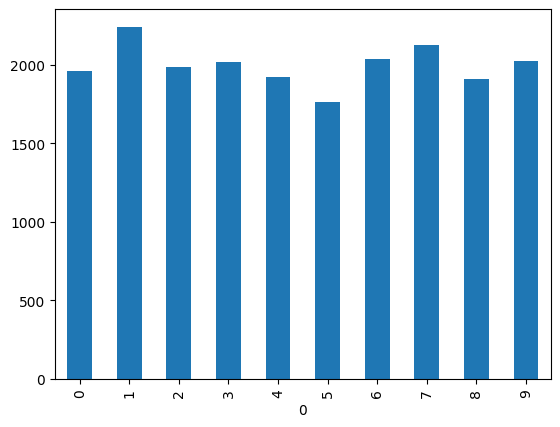

In [6]:
# What's the distribuiont of labels in the train set?
display(mnist_train[0].value_counts().sort_index().plot.bar())
display(mnist_train[0].value_counts(normalize=True).max())

<Axes: xlabel='0'>

0.1135

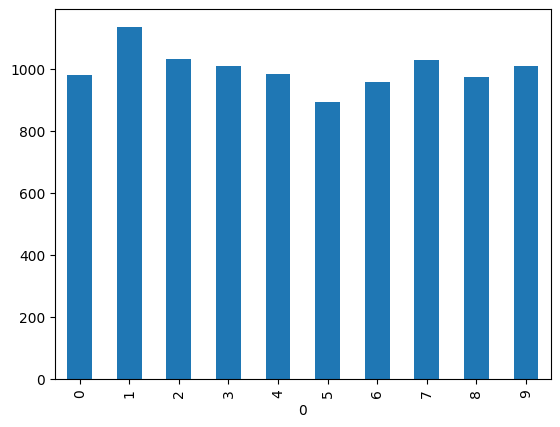

In [7]:
# What's the distribuion of labels in the validation set?
display(mnist_valid[0].value_counts().sort_index().plot.bar())
display(mnist_valid[0].value_counts(normalize=True).max())

In [8]:
def show_number(row, ax=None):
    """
    This function shows a row as an image, and titles it with the label.

    Options:
    * row: a row from either of the mnist_train or mnist_valid dataframes.
    * ax: if not None, will plot the digit on the provided ax.
        Otherwise, this function should create a figure and
    """
    return_fig = ax == None
    target, values = row.values[0], row.values[1:].reshape(28, 28)
    if not ax:
        fig, ax = plt.subplots()
    ax.imshow(values, cmap='gray_r')
    ax.set_title(target)

    plt.close()
    if return_fig:
        return fig

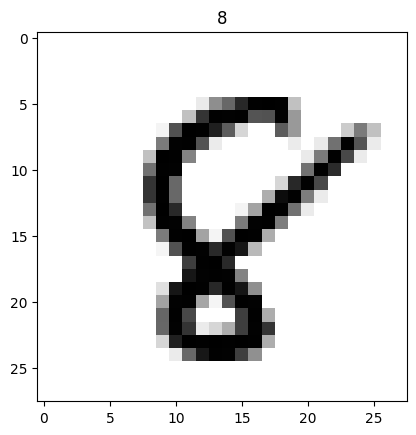

In [9]:
show_number(mnist_train.sample(1).iloc[0])

In [10]:
def show_many(n_rows=3, n_cols=3):
    """
    This function shows a number of images at a time, by default 9.
    It takes a random sample of (n_rows * n_cols) of the training data to show.
    """
    # Sample the training data
    train_df_sample = mnist_train.sample(n_rows * n_cols)
    # Create the figure
    fig = plt.figure(figsize=(4*n_cols, 4*n_rows))
    # For each row in the sample, plot the number
    for i, (_, row) in enumerate(train_df_sample.iterrows()):
        ax = fig.add_subplot(n_rows, n_cols, 1+i)
        show_number(row, ax)
    plt.close()
    return fig

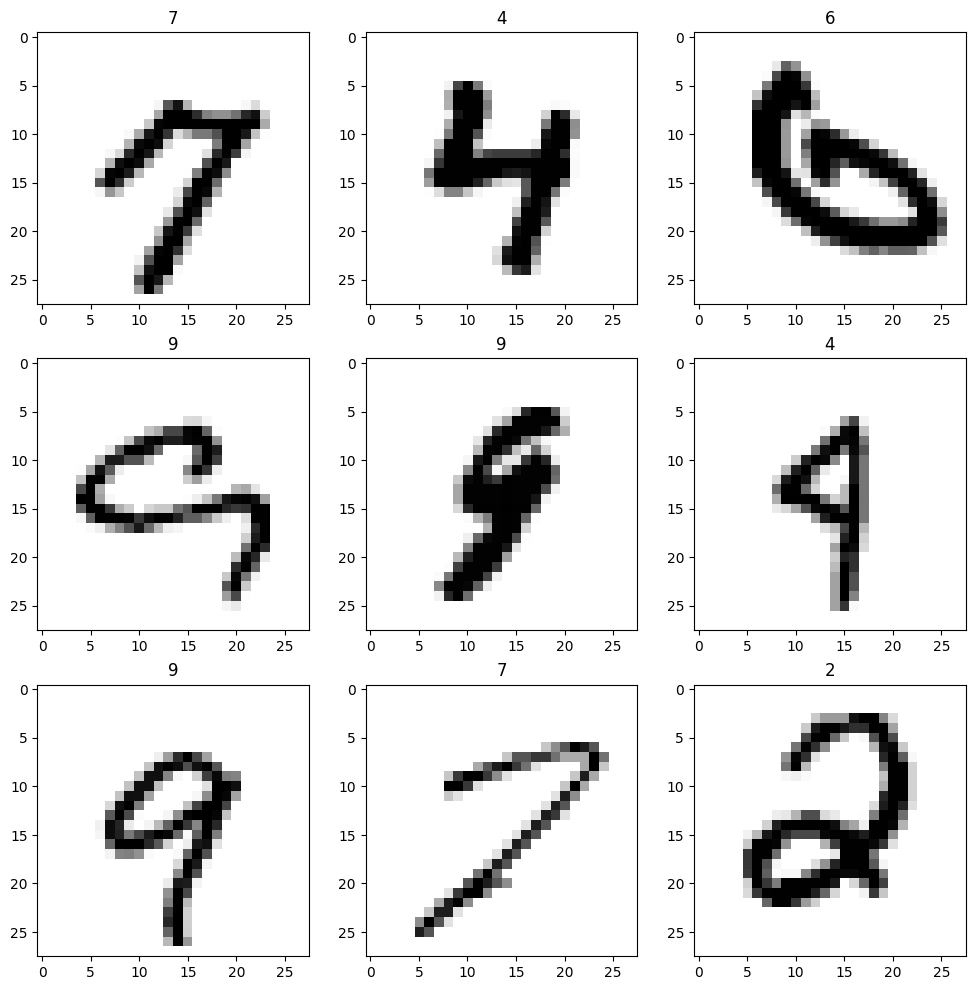

In [11]:
show_many()

In [12]:
# What are the min and max values of the data?
mnist_train.loc[:, 1:].values.max(), \
mnist_train.loc[:, 1:].values.min()

(np.int64(255), np.int64(0))

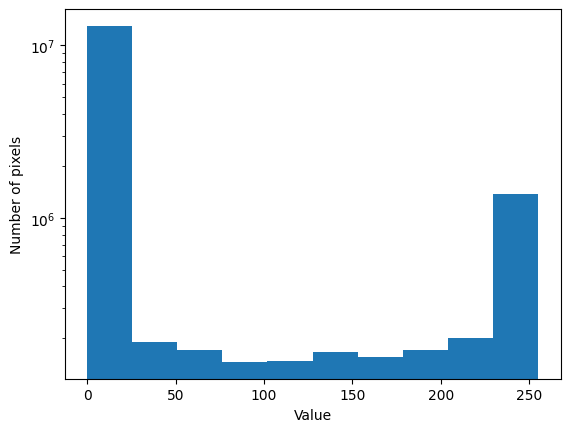

In [13]:
plt.hist(mnist_train.loc[:, 1:].values.ravel())
plt.ylabel('Number of pixels')
plt.xlabel('Value')
plt.yscale('log')

In [14]:
# Let's scale all the data between 0 and 1.
mnist_train_scaled = mnist_train.copy()
mnist_train_scaled.loc[:, 1:] /= 255

/tmp/ipython-input-269864905.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0. 0. 0. ... 0. 0. 0.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  mnist_train_scaled.loc[:, 1:] /= 255
/tmp/ipython-input-269864905.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0. 0. 0. ... 0. 0. 0.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  mnist_train_scaled.loc[:, 1:] /= 255
/tmp/ipython-input-269864905.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0. 0. 0. ... 0. 0. 0.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  mnist_train_scaled.loc[:, 1:] /= 255
/tmp/ipython-input-269864905.py:3: FutureWarning: Setting an item of incompatible dtype 

In [15]:
mnist_valid_scaled = mnist_valid.copy()
mnist_valid_scaled.loc[:, 1:] /= 255

/tmp/ipython-input-1392529688.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0. 0. 0. ... 0. 0. 0.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  mnist_valid_scaled.loc[:, 1:] /= 255
/tmp/ipython-input-1392529688.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0. 0. 0. ... 0. 0. 0.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  mnist_valid_scaled.loc[:, 1:] /= 255
/tmp/ipython-input-1392529688.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0. 0. 0. ... 0. 0. 0.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  mnist_valid_scaled.loc[:, 1:] /= 255
/tmp/ipython-input-1392529688.py:2: FutureWarning: Setting an item of incompatible dt

In [16]:
mnist_train_scaled.loc[:, 1:].values.max(), \
mnist_train_scaled.loc[:, 1:].values.min()

(np.float64(1.0), np.float64(0.0))

# Exercise 8.1

Now that we've preprocessed our data, we require objects to feed data to our model.
Using your knowledge about `torch` datasets, complete the `MnistDataset` class.
Your `__getitem__` method should return a tuple of two values - the first is a vector of lenth 784 representing the pixel values of the image, and the second is an integer representing the label (0-9).
Both items should be of type `torch.Tensor`.

<!-- startquestion -->


In [17]:
class MnistDataset(Dataset):
    def __init__(self, dataframe):
        super().__init__()
        self.dataframe = dataframe

    def __len__(self):
      return self.dataframe.shape[0]

    def __getitem__(self, idx):
        y = torch.tensor(self.dataframe.loc[idx,0])
        x = torch.FloatTensor(self.dataframe.loc[idx, 1:].values)
        return x, y

In [18]:
# Create datasets from the dataframes
train_ds = MnistDataset(mnist_train_scaled)
valid_ds = MnistDataset(mnist_valid_scaled)

In [19]:
# Sanity check!
_x, _y = train_ds[0]
assert _x.shape[0] == mnist_train_scaled.shape[1] - 1
assert _y == mnist_train_scaled.loc[0,0]

# Exercise 8.2

Now that we've created our datasets, use them to create our train and validation dataloaders.
Remember to shuffle your train dataloader but not your valid!

<!-- startquestion -->

In [20]:
# Create dataloaders from the datasets.
# During the training phase, we need to keep both the activations
# and the gradients in memory. However during the validation phase,
# we don't have to store gradients so we can double the batch size!
# doubled the batch size for the validation because we don't need to do both the forward and backward propogation in the validation set

train_dl = DataLoader(train_ds, batch_size=128, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=256, shuffle=False)

## Exercise 8.3: Build the Model


In [21]:
def linear(in_features, out_features, dropout=0.2):
    """
    Returns an nn.Sequential module that we want to repeat a lot.
    The module contains a linear layer, ReLU activation, BatchNorm, and dropout.
    """
    return nn.Sequential(
        nn.Linear(in_features, out_features),
        nn.ReLU(),
        nn.BatchNorm1d(out_features),
        nn.Dropout(dropout)
    )

In [22]:
# Sanity check!
assert len(linear(1,1)) == 4

In [30]:
# Define some parameters for the model
class Config():
    def __init__(self, num_input_features=28*28, n_hidden_layers=2, hidden_dim=256, n_labels=10):
        self.num_input_features = num_input_features
        self.n_hidden_layers = n_hidden_layers
        self.hidden_dim = hidden_dim
        self.n_labels = n_labels
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

config = Config()

In [ ]:
def build_model(config):
    if getattr(config, "n_hidden_layers", 0) and config.n_hidden_layers > 0:
      layers.append(linear(config.num_input_features, config.hidden_dim))
      for _ in range(config.n_hidden_layers - 1):
        layers.append(linear(config.hidden_dim, config.hidden_dim))
      layers.append(nn.Linear(config.hidden_dim, config.n_labels))
    else:
      layers.append(nn.Linear(config.num_input_features, config.n_labels))

    model = nn.Sequential(*layers).to(config.device)
    return model

In [ ]:
# instantiate the model
model = build_model(config)

In [ ]:
# if the model's not on the GPU but it's available, put it there.
print('Model device: ', next(model.parameters()).device)
if not next(model.parameters()).is_cuda & torch.cuda.is_available():
    print('Model is on CPU, but GPU is available. Putting model on GPU.')
    model = model.to(config.device)
    print('Model device: ', next(model.parameters()).device)

In [ ]:
# Sanity check!
assert len(model) == config.n_hidden_layers + 2

In [ ]:
# Another sanity check: our model should be able to operate on a batch of data.
for x_b, y_b in train_dl:
    break
model(x_b.to(config.device)).shape

In [ ]:
loss_func = ...
opt = ...
metric = torchmetrics.Accuracy()

In [ ]:
def train_step(x_b, y_b):
    # Send x_b and y_b to the GPU, if available
    x_b = x_b.to(config.device)
    y_b = y_b.to(config.device)
    # Generate yhat
    yhat = ...
    # Calculate the loss
    loss = ...
    # Calculate gradients

    # Perform your update and zero out your gradients
    opt
    opt

    # Update your accuracy metric. We'll give you this one!
    batch_acc = metric(yhat.cpu().softmax(axis=1), y_b.cpu())

    # Return the loss
    return loss

In [ ]:
def validation_step(x_b, y_b):
    # Send x_b and y_b to the GPU, if available
    x_b = ...
    y_b = ...
    # Tell torch not to calculate gradients on the validation batch
    with torch.no_grad():
        # Generate yhat
        yhat = ...
        # Calculate the loss
        loss = ...

    # Ok, you've seen this before, you do it this time!
    batch_acc = ...

    # Return the loss
    return loss

In [ ]:
N_EPOCHS = 10

In [ ]:
train_losses_step = []
train_losses = []
valid_losses = []
for epoch in range(N_EPOCHS):
    # Training loop
    model.train() # Put the model in train mode
    train_loss_epoch = 0.
    for x_b, y_b in train_dl:
        loss = train_step(x_b, y_b)
        train_loss_epoch += loss
        train_losses_step.append(loss.item())

    # Compute the train loss and accuracy for the epoch.
    # The epoch loss is a little bit off if our final batch
    # is a different size - we're going to ignore that for now,
    # since higher-level libraries will solve this for us.
    train_loss_epoch /= len(train_dl)
    train_losses.append(train_loss_epoch.item())
    train_acc = metric.compute()

    # Validation loop
    model.eval() # Put the model in eval mode (affects dropout and batch norm)
    val_loss_epoch = 0.
    for x_b, y_b in valid_dl:
        loss = validation_step(x_b, y_b)
        val_loss_epoch += loss

    val_loss_epoch /= len(valid_dl)
    valid_acc = metric.compute()
    valid_losses.append(val_loss_epoch.item())

    print(f"Epoch: {epoch}, Train loss: {train_loss_epoch:.04f} Train acc: {float(train_acc):.04f}, Valid loss: {val_loss_epoch} Valid Acc: {float(valid_acc):.04f}")

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20,8))
ax1, ax2 = axes
ax1.plot(train_losses_step, label='Train Loss')
ax2.plot(train_losses, label='Train Loss')
ax2.plot(valid_losses, label='Valid Loss')
ax1.legend()
ax2.legend()
ax1.set_xlabel('Step')
ax1.set_ylabel('Cross Entropy Loss')
ax2.set_xlabel('Epoch')

In [ ]:
def show_preds(sample=None):
    """
    Shows a actuals and inferences from a random sample of the validation dataset.
    """
    # Sample a few images
    if sample is None:
        sample = mnist_valid_scaled.sample(9)
    # Get the sample into a format we can feed into the model
    x_b = torch.FloatTensor(sample.loc[:, 1:].values)
    y_b = sample.loc[:,0].values

    # Make inferences on the sample
    model.eval()
    with torch.no_grad():
        # Get the inferences, apply softmax to convert to predicted probabilities,
        # and use argmax to get the index of the highest probability.
        # This is the digit!
        preds = model(x_b.to(config.device)).softmax(dim=-1).argmax(dim=-1).cpu().numpy()

    # Plot a 3x3 grid of digits, where the title
    # contains the predictiona nd the actual value.
    fig = plt.figure(figsize=(12, 12))
    for i, (x, y, p) in enumerate(zip(x_b, y_b, preds)):
        ax = fig.add_subplot(3, 3, 1+i)
        ax.matshow(x.reshape(28, 28), cmap='Greys_r')
        ax.set_title(f'Actual: {y}, Pred: {int(p)}')
        ax.set_xticks([])
        ax.set_yticks([])
    fig.tight_layout()
    plt.close()
    return fig

In [ ]:
show_preds()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [ ]:
probas = []
preds = []
losses = []
ys = []
model.eval()
for x_b, y_b in valid_dl:
    with torch.no_grad():
        logits = model(x_b.to(config.device)).cpu()
        _probas = logits.softmax(dim=-1).numpy()
        _preds = _probas.argmax(axis=-1)
        _losses = F.cross_entropy(logits, y_b, reduce=False)
    probas.append(_probas)
    preds.append(_preds)
    losses.append(_losses.numpy())
    ys.append(y_b.numpy())
probas = np.vstack(probas)
preds = np.concatenate(preds)
losses = np.concatenate(losses)
ys = np.concatenate(ys)

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix(ys, preds, normalize='true'), display_labels=range(10))
cm_fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)

In [ ]:
print(classification_report(ys, preds))

In [ ]:
# Your code here!